In [72]:
from nba_api.stats.static import players
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll

import pandas as pd 
import numpy as np
import time
import os

#-- Visualization
import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()


In [3]:
#-- Data 
nba_1718 = pd.read_csv('nba_2017_2018_per_game.csv')
nba_1819 = pd.read_csv('nba_2018_2019_per_game.csv')
nba_1920 = pd.read_csv('nba_2019_2020_per_game.csv')
nba_2021 = pd.read_csv('nba_2020_2021_per_game.csv')
nba_2122 = pd.read_csv('nba_2021_2022_per_game.csv')

### The Basketball Sharpe Ratio: Risk Adjusting Excess Points

If you've been following the NBA over the past few years, you'll be well aware of the scoring "inflation" that has taken place across the league. Gone are the days where being a 20+ points-per-game (PPG) scorer could get you an all-star nomination. Going back 10-years to the 2012-2013 NBA season, nine players averaged 20+ points-per-game. Go back five years to the 2017-2018 NBA season and you'll see 23 players averaged 20+ points-per-game. An in today's league for the 2022-2023 NBA season, a whoping 38 players are average 20+ points-per-game. In the past decade, the league has seen a 322% increase in 20+ point-per-game scorers. Sure, 20 is an arbitrary benchmark for someone who's considered a good scorer, but it goes to show the proliferation of points in today's league. 

While there are a host of factors that have given way to the scoring explosion over the past decade, free throws have always been a point of interest to me. Stephen Curry is one of the generation's elite scorers, and I've always admired his ability to create his own points off the dribble, meaning Steph can get buckets whenever he wants through his ability to get to the hoop, put up threes, or pop a mid-range jumper. In other words, Steph isn't realiant on the free-throw line or getting foul calls to get his points, or at least I'm of this belief. On the other hand, I can't help but think about Harden's MVP caliber years in Houston as being *heavily* reliant on getting foul calls on baited drivers and three-pointers. Harden generated historic scoring numbers during his MVP season, and to his credit he proved that he's one of the greatest to ever do it. But, his season stats prompted me to dig further into the source and value of his points. Basketball fans will know that despite Harden's massive offensive contribution, he dissapeared in the biggest moments and remains one of the 21st century MVPs without a NBA championship. Therefore, I'm left asking the question: **is there a better way to measure a player's offensive value besides pure PPG numbers?** 

Over the past semester I've gotten the chance study and work on problems in quantitative finance, leaving me with an interest to apply principles and concepts from this realm into other domains where applicable. One of the simplest but most influential contributions in this space is the Sharpe Ratio. The Sharpe Ratio, for those who aren't familiar with this concept, is an asset or portfolio performance metric created by William Sharpe back in 1996. This metric compares an investment's return with its risk, based on the belief that higher excess returns may come with greater volatility and risk over the same timeframe. When it comes to investing strategy, the Sharpe Ratio can be understood as a risk-adjusted performance metric to compare investing skill. 

$$ \textnormal{Sharpe} = \frac{\mu_{i} - r_f}{\sigma_{i}} $$

The two components of the Sharpe Ratio that pique my interest in using it explain better offensive output in the NBA are (1) excess returns and (2) return volatility. Excess returns in finance are measured by the actual return on an assets minus the risk-free return. The risk-free return is simply the expected return on an asset with zero risk. While there's no truly risk-free asset, most investors treat this so called "risk-free rate" as the rate of return they expected at minimum from parking their money somewhere, most likely being the safest or lowest risk asset out there. This is often represented through the rate of return on short-term government bonds.

I liken this back to basketball by considering risk-free points as free-throw attempts. A free-throw is quite literally a chance at "free" points. We can solve one of the original problems I had with understanding a player's offensive value by distilling their points scored from those points that came through free-throws. Free-throw attempts and makes aren't the same idea, but if you're a player getting a lot of free-throw attempts you should be expected to produce more points since you're given more chances at "free" points. Most investors will adopt the same risk-free rate but not all basketball players have the same amount of free-throw attempts per game, but makes the concept of "excess points" something unique and specific to each player. 

The second concept from the Sharpe Ratio which I connect back to basketball is return volatility. This should be more straightforward, but it is just the measure of an asset's standard deviation over some timeframe. To put this in a basketball context, I treat this component of the Sharpe Ratio as the standard deviation of a player's points-per-game over an NBA season.

$$ \textnormal{BB-Sharpe} = \frac{\mu_{ppg} - \mu_{fta}}{\sigma_{ppg}} $$

Above I represent the translated Sharpe Ratio into basketball (BB) terms. The rest of this paper looks into the behaviour of this metric over the past handful of NBA seasons and trys to show a more accurate understanding of a player's offensive value compared to their raw PPG numbers. 


In [123]:
#-- Get Player Names Dictionary
player_dict = players.get_players()

#-- Define Function for Getting Season Games

def player_gl_api(player_name, season_year):
    
    nba_player = [player for player in player_dict if player['full_name'] == player_name][0]
    nba_player_id = nba_player['id']
    gamelog_nba_player = playergamelog.PlayerGameLog(player_id = nba_player_id, season = season_year)
    nba_player_gamelog_df = gamelog_nba_player.get_data_frames()[0]
    nba_player_gamelog_df['PLAYER'] = player_name

    return nba_player_gamelog_df

def get_bb_sharpe(player_name, season_year):
    
    nba_player = [player for player in player_dict if player['full_name'] == player_name][0]
    nba_player_id = nba_player['id']
    gamelog_nba_player = playergamelog.PlayerGameLog(player_id = nba_player_id, season = season_year)
    nba_player_gamelog_df = gamelog_nba_player.get_data_frames()[0]
    nba_player_gamelog_df['PLAYER'] = player_name

    games = len(nba_player_gamelog_df)
    fts = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['PTS'])
    mu_ftper = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['FTA'])
    mu_ppg = np.mean(nba_player_gamelog_df['PTS'])
    mu_fta = np.mean(nba_player_gamelog_df['FTA'])
    sigma_ppg = np.std(nba_player_gamelog_df['PTS'])
    ppg_fta_cov = np.cov(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    ppg_fta_corr = np.corrcoef(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    bb_sharpe_2 = (mu_ppg - mu_fta) / np.sqrt(ppg_fta_cov)

    basketball_sharpe = (mu_ppg - mu_fta) / sigma_ppg

    temp_df = {'Player' : player_name, 'Season' : season_year, 'Games Played' : games
                , 'Average PPG' : mu_ppg, 'Volatility PPG' : sigma_ppg
                , 'Average FTA' : mu_fta, 'Average FTPER' : mu_ftper, 'Average FTS' : fts, 'nbaBB Sharpe' : basketball_sharpe
                , 'FTA PTS Correlation' : ppg_fta_corr, 'FTA PTS Covariance' : ppg_fta_cov, 'nbaBB Sharpe2' : bb_sharpe_2}

    temp_df = pd.DataFrame(temp_df, index = [0])

    return temp_df    

#-- Year Range BB Sharpe Function --#

def get_bb_sharpe_years(player_name, start_year, end_year):
    
    base = get_bb_sharpe(player_name, str(start_year))

    for year in range(start_year + 1, end_year + 1):
        base = pd.concat( [ base, get_bb_sharpe(player_name, str(year)) ] )
    
    return base

In [95]:
#-----------------------------------------------------------#
#           Last Season BB-Sharpe Visualization             #
#-----------------------------------------------------------#

#------------- Scrape Data ------------------#

top_25_2122 = nba_2122.sort_values(by = 'PTS', ascending = False).reset_index().iloc[0:26, 2]

last_season_df = pd.DataFrame()

for p in top_25_2122:
    
    try: 
        data = get_bb_sharpe(p, '2021')
        
        last_season_df = pd.concat([last_season_df, data], ignore_index = True)

        time.sleep(5)
    except:
        pass    

#------------- Build Visualization ------------------#

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = np.round(last_season_df['nbaBB Sharpe'], 2), y = np.round(last_season_df['Average PPG'], 2)
        , marker=dict(
            size=16
            #, cmax=1
            #, cmin=0
            , color = last_season_df['Average FTPER']
            , colorbar=dict(
                title = "Avg. FT %"
            )
            , colorscale="Viridis"
        )
        , mode = "markers"
        , text = last_season_df['Player']
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'Basketball Sharpe Ratios from the 2021-2022 NBA Season for a Sample of the Top Scorers'
                    , xaxis_title = 'Sharpe Ratios'
                    , yaxis_title = 'Average Points Per Game'
                    , autosize = True)

fig.show()

In [125]:
#-----------------------------------------------------------#
#           Last Season BB-Sharpe Visualization             #
#-----------------------------------------------------------#

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = np.round(last_season_df['nbaBB Sharpe'], 2), y = np.round(last_season_df['Average PPG'], 2)
        , marker=dict(
            size=16
            #, cmax=1
            #, cmin=0
            , color = last_season_df['Average FTPER']
            , colorbar=dict(
                title = "Avg. FT %"
            )
            , colorscale="Viridis"
        )
        , mode = "markers"
        , text = last_season_df['Player']
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'Basketball Sharpe Ratios from the 2021-2022 NBA Season for a Sample of the Top Scorers'
                    , xaxis_title = 'Sharpe Ratios'
                    , yaxis_title = 'Average Points Per Game'
                    , autosize = True)

fig.show()

The scatterplot from above shows the relationship between BB-Sharpe Ratios and average points per game for players from the 2021-2022 NBA season. Joel Embiid won the league scoring title in a close race with LeBron, but if this analysis proves anything, it would suggest that LeBron is in a world of his own for true offensive value. LeBron has the highest BB-Sharpe Ratio out of all top scorers this season, and he averaged the second highest points per game. His BB-Sharpe Ratio is .24 higher than the next closest players who comparably average 4 and 6 fewer points a game, respectively. Moreover, the color-scale doesn't mean a ton for this plot, but it does show the free-throw percentage of players where LeBron is among the worst free-throw shooters captured in this sample. For what it's worth, he's leaving the few points on the table that he could be adding to his output as he's not as comporably efficient of a free-throw shooter.

While league scoring champion and MVP runner-up Joel Embiid might have average the most points-per-game last season, his BB-Sharpe Ratio is much lower compared to a handful of other top scorers. Embiid is known for getting a lot of his points from the free-throw line, and therefore he is expected to generate lower excess points compared to other players who play more on the perimeter and stay away from the "bruiser" style of basketball that big men tend towards. Nonetheless, if Embiid is going to generate lower excess points in comparison to other top scorers, his scoring volatility ($\sigma+{ppg}) should also be lower since he's given more opportunities on a nightly basis to get "free" points. If this held true, then he would have a BB-Sharpe Ratio that's consistent with other top scorers. However, as evidenced by the lower BB-Sharpe Ratio, we can take away that Joel Embiid must also present greater volatility in his point-per-game output despite the greater share of opportunities for "free" points.

In [65]:
np.cov(HARDEN18['PTS'], HARDEN18['FTA'])[1][0]
np.corrcoef(HARDEN18['PTS'], HARDEN18['FTA'])[1][0]

0.6924546287313847

In [71]:
get_bb_sharpe('James Harden', '2017')

,Player,Season,Games Played,Average PPG,Volatility PPG,Average FTA,Average FTPER,Average FTS,nbaBB Sharpe
0,James Harden,2017,72,30.430556,9.104069,10.097222,0.858364,0.285476,2.233434


In [69]:
HARDEN18 = player_gl_api('James Harden', '2017')
HARDEN18['GAME_DATE'] = pd.to_datetime(HARDEN18['GAME_DATE'])

fig = go.Figure()

fig.add_trace(go.Scatter(x = HARDEN18['GAME_DATE'], y = HARDEN18['FTA'], mode = 'lines+markers', name = 'FTA'))
fig.add_trace(go.Scatter(x = HARDEN18['GAME_DATE'], y = HARDEN18['PTS'], mode = 'lines+markers', name = 'PTS'))

#fig.add_trace(go.Scatter(x = df_stocks.date, y = df_stocks['GOOG'], mode = 'lines+markers', name = 'GOOG',
#                            line = dict(color = 'firebrick', width = 2, dash = 'dashdot')))

fig.update_layout(title = 'James Harden 2017-2018 Gamelog Data'
                    , xaxis_title = 'Date'
                    , yaxis_title = 'PTS & FTA'
                    , xaxis = dict(showline = True
                                    , showgrid = True
                                    , showticklabels = True
                                    , linecolor = 'rgb(204, 204, 204)'
                                    , linewidth = 2
                                    , ticks = 'outside'
                                    , tickfont = dict(
                                        family = 'Arial'
                                        , size = 12
                                        , color = 'rgb(82, 82, 82)'
                                        )
                                    )
                    , yaxis = dict(showgrid = True
                                    , zeroline = True
                                    , showline = True
                                    , showticklabels = True
                                    )
                    , autosize = True
                    , margin = dict(autoexpand = True
                                    , l = 100
                                    , r = 200
                                    , t = 110
                                    )
                    , showlegend = True
                    , plot_bgcolor = 'white'
                    )

In [94]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = HARDEN18['FTA'], y = HARDEN18['PTS']
        , mode = 'markers'
        , marker = dict(
            size = 10
            , color = (HARDEN18['FTM'] / HARDEN18['PTS'])
            , colorscale = 'Viridis'
            , showscale = True
        )
    )
)

fig

In [74]:
top_30_1718 = nba_1718.iloc[0:31, 1].to_list()

In [18]:
output_df = pd.DataFrame()
dame = get_bb_sharpe_years('Damian Lillard', 2013, 2021)
output_df = pd.concat([output_df, dame], ignore_index=True)
output_df.head()

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Damian Lillard,2013,82,20.670732,5.195122,0.870637,7.368448,2.100254
1,Damian Lillard,2014,82,20.975610,4.853659,0.838103,7.440783,2.166701
2,Damian Lillard,2015,75,25.053333,6.186667,0.879055,8.329695,2.264989
3,Damian Lillard,2016,75,26.986667,7.266667,0.876503,8.562699,2.303012
4,Damian Lillard,2017,73,26.876712,7.369863,0.913009,7.856496,2.482894


In [32]:
top_25_2122 = nba_2122.sort_values(by = 'PTS', ascending = False).reset_index().iloc[0:26, 2]

df = get_bb_sharpe(top_25_2122[0], '2022')

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Joel Embiid,2022,22,32.545455,12.0,0.842337,9.916594,2.071826


In [88]:
output_df = pd.DataFrame()

for p in top_25_2122:
    
    try: 
        data = get_bb_sharpe(p, '2022')
        
        output_df = pd.concat([output_df, data], ignore_index = True)

        time.sleep(5)
    except:
        pass

In [75]:
TS_201718 = pd.DataFrame()

for p in top_30_1718:
    
    try: 
        data = get_bb_sharpe(p, '2017')
        
        TS_201718 = pd.concat([TS_201718, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

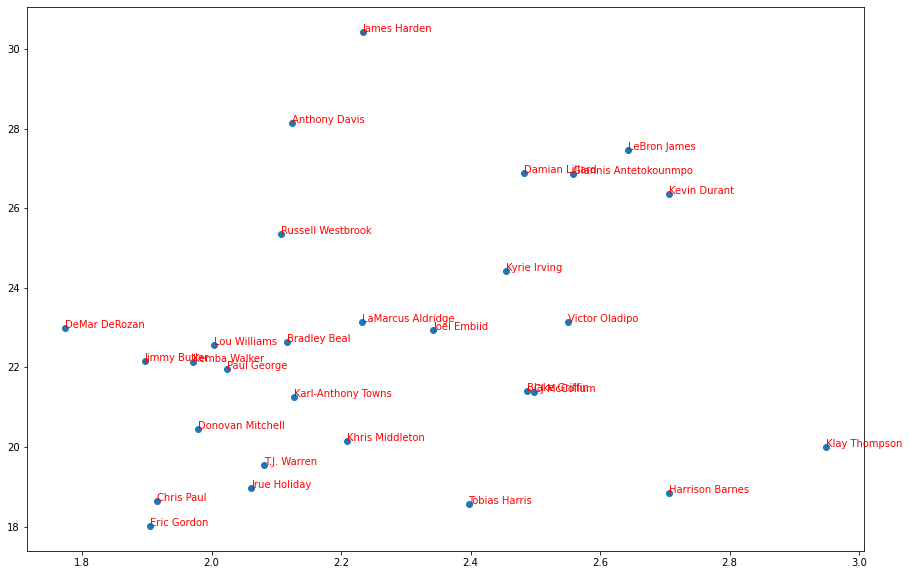

In [91]:
plt.figure(figsize = (15, 10))

plt.scatter(x = TS_201718['nbaBB Sharpe'], y = TS_201718['Average PPG'])

for i in range(0, len(TS_201718)):
    plt.text(x = TS_201718['nbaBB Sharpe'][i], y = TS_201718['Average PPG'][i], s = TS_201718['Player'][i]
                , fontdict = dict(color = 'red', size = 10)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

plt.show()

In [93]:
#
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = np.round(TS_201718['nbaBB Sharpe'], 2), y = np.round(TS_201718['Average PPG'], 2)
    , mode = 'markers'
    , marker = dict(color = TS_201718['Average FTPER'])
    , text = TS_201718['Player'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'BB-Sharpe Ratios from the 2021-2022 NBA Season'
                    , xaxis_title = 'BB-Sharpe Ratios'
                    , yaxis_title = 'Average PPG'
                    , showlegend = True
                    , autosize = True)

fig

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = output_df['nbaBB Sharpe'], y = output_df['Average PPG']
    , mode = 'markers', marker_color = output_df['Average FTPER']
    , text = output_df['Player'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'BB-Sharpe Ratios from the 2021-2022 NBA Season'
                    , xaxis_title = 'BB-Sharpe Ratios'
                    , yaxis_title = 'Average PPG')

fig

In [40]:




fig.add_trace(go.Scatter( x = output_df['nbaBB Sharpe'], y = output_df['Average PPG']
    , mode = 'markers', marker_color = output_df['Average FTPER']
    , text = output_df['species'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Joel Embiid,2022,22,32.545455,12.000000,0.842337,9.916594,2.071826
1,LeBron James,2022,23,27.130435,5.086957,0.676346,5.727921,3.848426
2,Giannis Antetokounmpo,2022,26,31.576923,12.615385,0.639641,8.091653,2.343345
3,Kevin Durant,2022,31,30.129032,7.387097,0.932941,6.819053,3.335058
4,Trae Young,2022,29,27.551724,8.620690,0.879063,7.609369,2.487859
5,DeMar DeRozan,2022,31,25.870968,8.096774,0.895574,8.885443,2.000372
6,Kyrie Irving,2022,22,26.136364,4.363636,0.935298,8.513601,2.557405
7,Ja Morant,2022,25,27.040000,8.680000,0.711195,9.083964,2.021144
8,Jayson Tatum,2022,30,30.566667,8.333333,0.874606,8.277211,2.686090
9,Devin Booker,2022,28,28.000000,6.428571,0.861833,11.671088,1.848279


In [16]:
px.scatter(get_bb_sharpe_years('Damian Lillard', 2013, 2021), x = 'nbaBB Sharpe', y = 'Average PPG', color = 'Season')

In [14]:
nba_mvps = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'Russell Westbrook', 'James Harden'
            , 'Giannis Antetokounmpo', 'Nikola Jokic']

bron = get_bb_sharpe('LeBron James', '2013')

for i in range(2014, 2022):
    bron = pd.concat( [bron, get_bb_sharpe('LeBron James', str(i))] )

steph = get_bb_sharpe('Stephen Curry', '2013')

for i in range(2014, 2022):
    steph = pd.concat( [steph, get_bb_sharpe('Stephen Curry', str(i))] )

giannis = get_bb_sharpe('Giannis Antetokounmpo', '2013')

for i in range(2014, 2022):
    giannis = pd.concat( [giannis, get_bb_sharpe('Giannis Antetokounmpo', str(i))] )

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [104]:
base_year = 20

for player in nba_mvps:

    

    for year in range(2014, 2022):

        base_1 = get_bb_sharpe

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,Stephen Curry,2021,64,25.468750,4.656250,9.937254,2.094391
1,Giannis Antetokounmpo,2021,67,29.880597,11.432836,7.876893,2.342010
2,LeBron James,2021,56,30.267857,6.000000,7.872854,3.082473
3,Stephen Curry,2020,63,31.984127,6.269841,10.299471,2.496661
4,Giannis Antetokounmpo,2020,61,28.147541,9.524590,8.934802,2.084316
5,LeBron James,2020,45,25.022222,5.666667,6.591203,2.936574
6,Stephen Curry,2019,5,20.800000,5.200000,6.013319,2.594241
7,Giannis Antetokounmpo,2019,63,29.476190,9.984127,7.623808,2.556736
8,LeBron James,2019,67,25.343284,5.686567,6.527902,3.011185
9,LeBron James,2018,55,27.363636,7.600000,7.022985,2.814136


In [108]:
df = pd.concat([giannis, bron, steph]).sort_values('Season', ascending = True).reset_index().drop(columns = ['index'])
px.line(df, x = 'Season', y = 'nbaBB Sharpe', color = 'Player')

In [80]:
bron

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,LeBron James,2013,77,27.129870,7.597403,8.328251,2.345327
0,LeBron James,2014,69,25.260870,7.652174,6.983733,2.521387
0,LeBron James,2015,76,25.263158,6.460526,5.983241,3.142550
0,LeBron James,2016,74,26.405405,7.175676,6.044696,3.181257
0,LeBron James,2017,82,27.451220,6.475610,7.934415,2.643624
0,LeBron James,2018,55,27.363636,7.600000,7.022985,2.814136
0,LeBron James,2019,67,25.343284,5.686567,6.527902,3.011185
0,LeBron James,2020,45,25.022222,5.666667,6.591203,2.936574
0,LeBron James,2021,56,30.267857,6.000000,7.872854,3.082473


In [81]:
steph

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,LeBron James,2013,77,27.129870,7.597403,8.328251,2.345327
0,Stephen Curry,2014,80,23.750000,4.212500,8.104783,2.410614
0,Stephen Curry,2015,79,30.063291,5.063291,9.702331,2.576700
0,Stephen Curry,2016,79,25.303797,4.582278,7.646219,2.710035
0,Stephen Curry,2017,51,26.392157,5.921569,8.510843,2.405236
0,Stephen Curry,2018,69,27.260870,4.159420,9.663396,2.390614
0,Stephen Curry,2019,5,20.800000,5.200000,6.013319,2.594241
0,Stephen Curry,2020,63,31.984127,6.269841,10.299471,2.496661
0,Stephen Curry,2021,64,25.468750,4.656250,9.937254,2.094391


In [30]:
harden_18 = player_gl_api('Damian Lillard', '2018')

( np.mean(harden_18['PTS']) - np.mean(harden_18['FTA']) ) / np.std(harden_18['PTS'])

2.3606473442743074

In [ ]:
top_25_17_18 = ['James Harden', 'Anthony Davis', 'LeBron James', 'Giannis Antetokounmpo', 'Damian Lillard', 'Kevin Durant', 'Russell Westbrook']

In [70]:
from nba_api.stats import endpoints

data = endpoints.leagueleaders.LeagueLeaders()

data = data.get_data_frames()[0]

data.sort_values(by = 'PTS', ascending = False)

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,201142,1,Kevin Durant,1610612751,BKN,31,1130,335,594,0.564,...,205,163,26,49,109,73,934,992,1.50,0.24
1,1629029,1,Luka Doncic,1610612742,DAL,29,1054,318,644,0.494,...,240,251,47,17,106,81,934,980,2.37,0.44
2,1628369,3,Jayson Tatum,1610612738,BOS,30,1115,301,638,0.472,...,243,122,34,28,82,63,917,890,1.49,0.41
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,29,1034,299,600,0.498,...,135,166,49,29,99,75,904,862,1.68,0.49
4,1628378,5,Donovan Mitchell,1610612739,CLE,29,1056,298,592,0.503,...,110,130,39,10,85,77,855,748,1.53,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1631306,477,Cole Swider,1610612747,LAL,1,2,0,1,0.000,...,1,1,0,0,0,0,0,1,0.00,0.00
478,1628998,477,Cody Martin,1610612766,CHA,1,1,0,0,0.000,...,0,0,0,0,0,0,0,0,0.00,0.00
477,1631205,477,Buddy Boeheim,1610612765,DET,1,1,0,0,0.000,...,0,0,0,0,0,0,0,0,0.00,0.00
476,1631214,477,Alondes Williams,1610612751,BKN,1,5,0,0,0.000,...,1,0,0,0,2,1,0,-1,0.00,0.00
